# 🔍 AI/Human 텍스트 분류 설명가능성 분석 (Explainability)

## 📋 개요

학습된 BERT 모델이 **왜** 특정 문단/문서를 AI 또는 Human으로 분류했는지 설명하는 종합 분석 시스템

### 주요 분석 방법

1. **🎨 Attention Weights 시각화**
   - BERT가 어떤 토큰에 집중했는지 확인
   - Layer별, Head별 attention 패턴 분석

2. **📊 SHAP/LIME 토큰 기여도**
   - 각 단어가 AI/Human 판단에 얼마나 기여했는지
   - 긍정적/부정적 영향 시각화

3. **🧪 문단별 기여도 분석 (Ablation Study)**
   - 각 문단을 제거했을 때 예측 변화
   - 결정적인 문단 식별

4. **🎯 Interactive 문서 시각화**
   - Plotly로 문서 전체 색상 표현
   - 마우스 오버로 상세 정보 확인

5. **💬 Rationale 자동 추출**
   - "이 문서는 AI입니다. 왜냐하면..."
   - 자연어로 설명 생성

---
**전제 조건**: `bert_paragraph_classifier_colab.ipynb`에서 모델 학습 완료

## 🔧 환경 설정

In [1]:
# Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 필요한 라이브러리 설치
!pip install -q transformers datasets
!pip install -q shap lime
!pip install -q plotly bertviz
!pip install -q captum  # PyTorch Interpretability

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.5/157.5 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 145.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 88.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 400.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 123.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "

In [2]:
# Numba(<2.1)와 SHAP(>=2.0)의 호환성을 위해 NumPy 버전을 2.0.x로 고정
!pip install "numpy>=2.0,<2.1" pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 122.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.4.1
    Uninstalling numpy-2.4.1:
      Successfully uninstalled numpy-2.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
captum 0.8.0 requires numpy<2.0, but you have numpy 2.0.2 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.


In [1]:
# # 한글 폰트 설치 (반드시 런타임 재시작 필요!)
# !apt-get install -qq fonts-nanum
# !fc-cache -fv

/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/nanum: skipping, looped directory detected
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache director

In [1]:
# 폰트 캐시 새로고침
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 폰트 경로 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

print("✅ 한글 폰트 설정 완료")

✅ 한글 폰트 설정 완료


In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import json
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# SHAP & LIME
import shap
from lime.lime_text import LimeTextExplainer

# BertViz for attention
from bertviz import model_view, head_view

# Captum for integrated gradients
from captum.attr import LayerIntegratedGradients, visualization

# 한글 폰트
!apt-get install -qq fonts-nanum
import matplotlib.font_manager as fm
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️  디바이스: {device}")

🖥️  디바이스: cuda


## 📁 경로 및 모델 로드

In [3]:
# 경로 설정
BASE_PATH = '/content/drive/MyDrive/멋사_프로젝트_01/'
CHECKPOINT_DIR = os.path.join(BASE_PATH, 'checkpoints')
EXPLAINABILITY_DIR = os.path.join(BASE_PATH, 'explainability')
os.makedirs(EXPLAINABILITY_DIR, exist_ok=True)

print(f"📁 Explainability 결과 저장 위치: {EXPLAINABILITY_DIR}")

📁 Explainability 결과 저장 위치: /content/drive/MyDrive/멋사_프로젝트_01/explainability


In [4]:
# 모델 클래스 정의 (Attention 출력 추가)
class BERTParagraphClassifier(nn.Module):
    def __init__(self, model_name, num_classes=2, dropout=0.1):
        super(BERTParagraphClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask, output_attentions=False):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_attentions=output_attentions
        )
        cls_embedding = outputs.last_hidden_state[:, 0, :]
        cls_embedding = self.dropout(cls_embedding)
        logits = self.classifier(cls_embedding)

        if output_attentions:
            return logits, outputs.attentions
        return logits

# 모델 및 토크나이저 로드
MODEL_NAME = 'klue/bert-base'
MAX_LENGTH = 512

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = BERTParagraphClassifier(MODEL_NAME, num_classes=2, dropout=0.1)
checkpoint = torch.load(f'{CHECKPOINT_DIR}/best_model.pt', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

print(f"✅ 모델 로드 완료 (F1: {checkpoint['f1']:.4f})")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


✅ 모델 로드 완료 (F1: 0.6969)


## 📝 샘플 텍스트 준비

In [18]:
# 샘플 텍스트 준비 셀을 이렇게 수정해:

# ========== 실제 데이터셋 로드 ==========
DATA_PATH = os.path.join(BASE_PATH, 'train.csv')

df = pd.read_csv(DATA_PATH)
print(f"📁 데이터 로드: {len(df)} 문서")
print(f"컬럼: {df.columns.tolist()}")

# 레이블별 샘플 추출
n_samples = 5  # 분석할 샘플 수

# Human 샘플 (generated=0)
human_samples = df[df['generated'] == 0].sample(n_samples, random_state=42)

# AI 샘플 (generated=1)
ai_samples = df[df['generated'] == 1].sample(n_samples, random_state=42)

# 분석용 데이터프레임 생성
analysis_df = pd.concat([human_samples, ai_samples]).reset_index(drop=True)
print(f"\n📝 분석 샘플: {len(analysis_df)}개 (Human: {n_samples}, AI: {n_samples})")

# 샘플 텍스트 리스트 (기존 코드와 호환)
sample_paragraphs = analysis_df['full_text'].tolist()
sample_labels = analysis_df['generated'].tolist()

# 샘플 미리보기
for i, row in analysis_df.head(5).iterrows():
    label = "AI" if row['generated'] == 1 else "Human"
    print(f"\n[{label}] {row['full_text'][:100]}...")

📁 데이터 로드: 97172 문서
컬럼: ['title', 'full_text', 'generated']

📝 분석 샘플: 10개 (Human: 5, AI: 5)

[Human] 에덴 동산 또는 에덴(, )은 구약성경의 창세기에서 야훼가 최초의 사람인 아담과 하와를 위해 만들어 살게 했다는 이상향의 이름이다. 아브라함 계통 종교들의 창조 신화에 등장하는 이...

[Human] 세르게이 보그다노비치 세마크(, , 1976년 2월 27일, 우크라이나 SSR 시한스케 ~ )는 러시아의 은퇴한 축구 선수로, 포지션은 수비형 미드필더였다. 
 세마크는 우크라이나...

[Human] 심해 탐사는 과학적 또는 상업적 목적으로 해저의 물리적, 화학적 및 생물학적 조건을 조사하는 것이다. 심해 탐사는 다른 지구물리학 연구 분야에 비해 비교적 최근의 인간 활동으로 간...

[Human] 자기애( Self-love )는 '자기를 사랑함' 또는 '자신의 행복 또는 이익에 대하여'라는 의미로 기본적인 인간의 필요를 개념화하는 용어로 사용된다. 또한 도덕적 결함이라는 의...

[Human] 2행정 기관은 피스톤이 상승하면서 흡입과 압축이 이루어지고, 하강하면서 폭발과 배기가 이루어지는 총 2행정으로 사이클이 완료된다. 2행정 엔진의 한 사이클이 완료되면 크랭크 축과 ...


## 1️⃣ Attention Weights 시각화

BERT의 각 Layer, Head가 어떤 토큰에 집중했는지 시각화


샘플 1 | Label: Human
에덴 동산 또는 에덴(, )은 구약성경의 창세기에서 야훼가 최초의 사람인 아담과 하와를 위해 만들어 살게 했다는 이상향의 이름이다. 아브라함 계통 종교들의 창조 신화에 등장하는 이 정원은 기독교가 세계적으로 전파되면서 널리 알려지게 되었고, 오늘날에는 낙원의 대명사로서...


/tmp/ipython-input-3339330209.py:89: UserWarning:

Glyph 128100 (\N{BUST IN SILHOUETTE}) missing from font(s) NanumGothic.

/tmp/ipython-input-3339330209.py:101: UserWarning:

Glyph 128100 (\N{BUST IN SILHOUETTE}) missing from font(s) NanumGothic.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128100 (\N{BUST IN SILHOUETTE}) missing from font(s) NanumGothic.



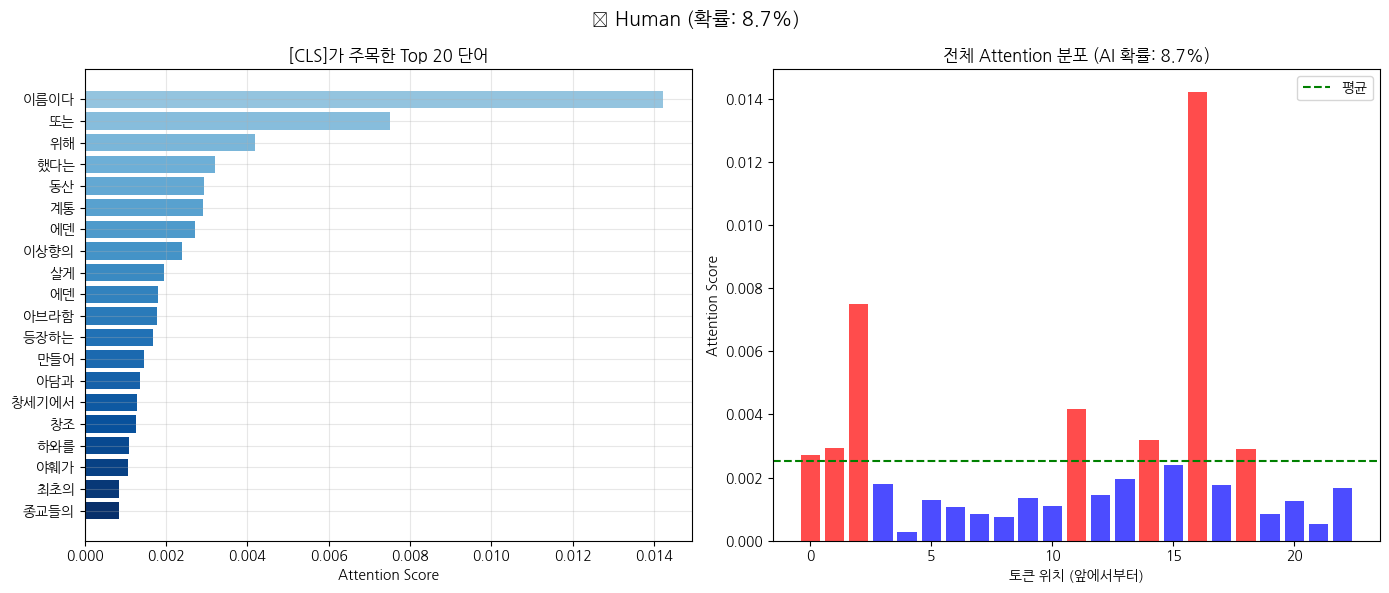


샘플 2 | Label: Human
세르게이 보그다노비치 세마크(, , 1976년 2월 27일, 우크라이나 SSR 시한스케 ~ )는 러시아의 은퇴한 축구 선수로, 포지션은 수비형 미드필더였다. 
 세마크는 우크라이나 루한스크주의 시한스케에서 태어나, 루한스크 축구 학교를 다녔다. 1992년 프레스냐 모스...


/tmp/ipython-input-3339330209.py:89: UserWarning:

Glyph 129302 (\N{ROBOT FACE}) missing from font(s) NanumGothic.

/tmp/ipython-input-3339330209.py:101: UserWarning:

Glyph 129302 (\N{ROBOT FACE}) missing from font(s) NanumGothic.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 129302 (\N{ROBOT FACE}) missing from font(s) NanumGothic.



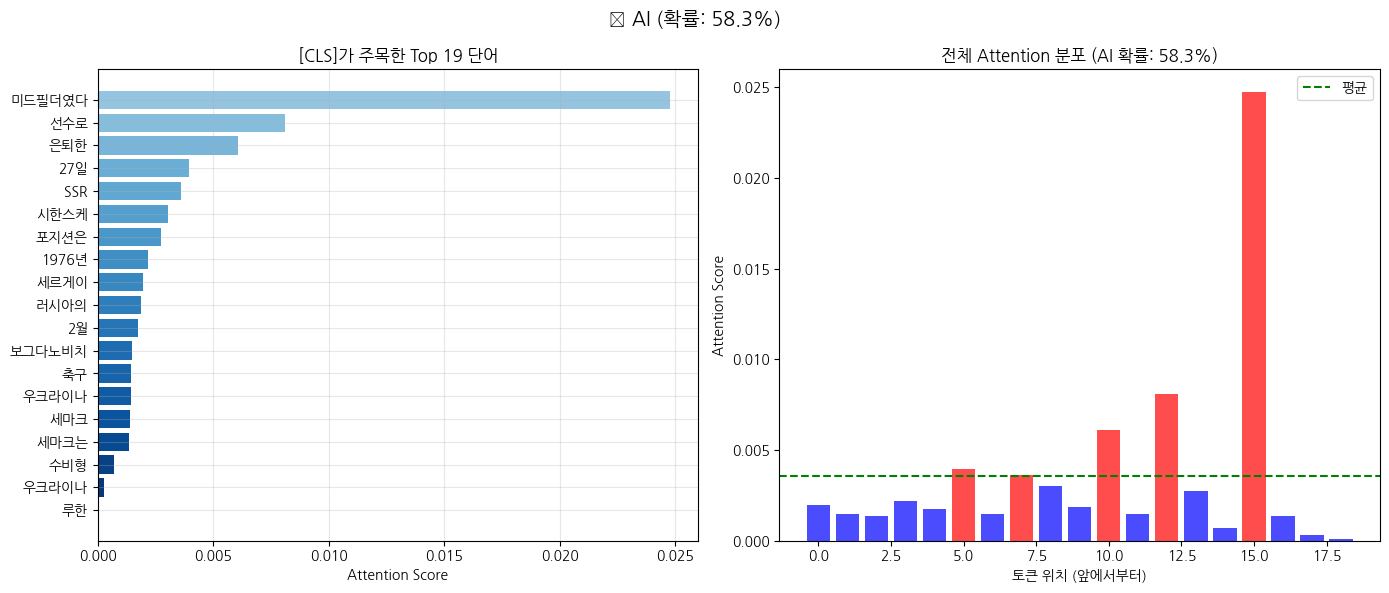


샘플 3 | Label: Human
심해 탐사는 과학적 또는 상업적 목적으로 해저의 물리적, 화학적 및 생물학적 조건을 조사하는 것이다. 심해 탐사는 다른 지구물리학 연구 분야에 비해 비교적 최근의 인간 활동으로 간주된다. 심해 탐사는 비교적 최근 몇 년 동안만 이루어졌기 때문이다. 심해는 여전히 대부분...


/tmp/ipython-input-3339330209.py:89: UserWarning:

Glyph 128100 (\N{BUST IN SILHOUETTE}) missing from font(s) NanumGothic.

/tmp/ipython-input-3339330209.py:101: UserWarning:

Glyph 128100 (\N{BUST IN SILHOUETTE}) missing from font(s) NanumGothic.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128100 (\N{BUST IN SILHOUETTE}) missing from font(s) NanumGothic.



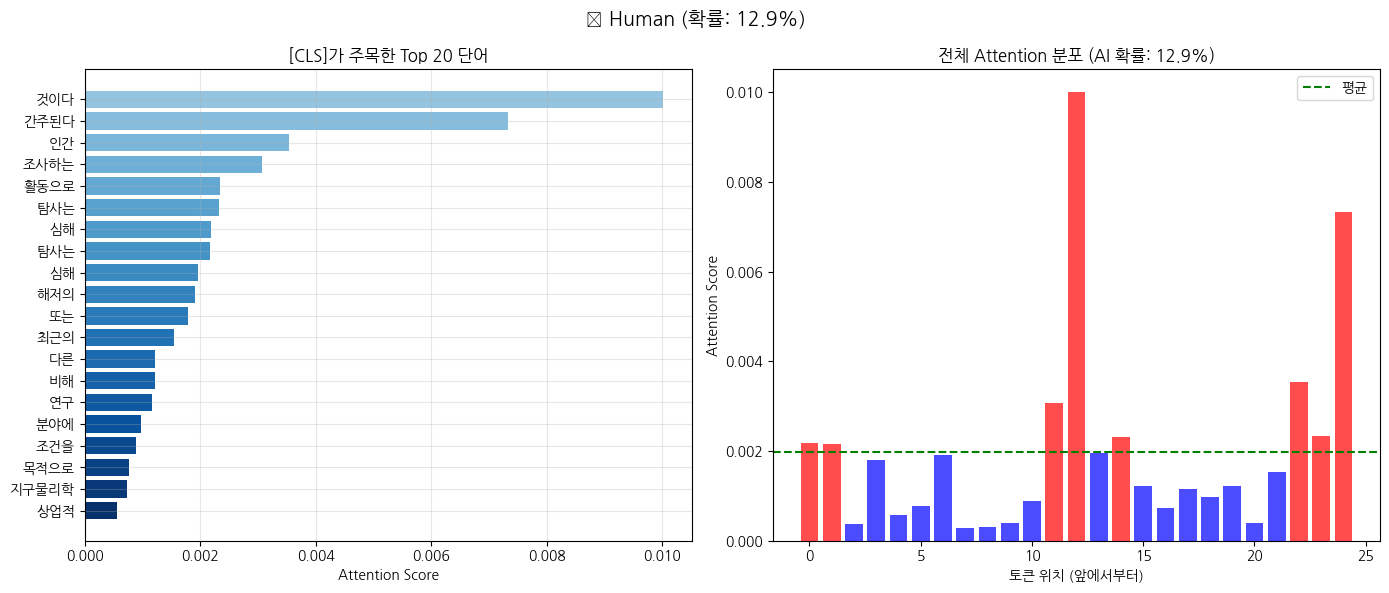

In [25]:
def visualize_attention_improved(text, model, tokenizer, device, layer_idx=-1, max_tokens=50):
    """
    개선된 Attention 시각화 - CLS 토큰 관점에서 중요 단어 표시
    """
    # Tokenization
    inputs = tokenizer(text, return_tensors='pt', max_length=MAX_LENGTH,
                      padding='max_length', truncation=True)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # Forward pass with attention
    with torch.no_grad():
        logits, attentions = model(input_ids, attention_mask, output_attentions=True)
        probs = F.softmax(logits, dim=1)
        ai_prob = probs[0, 1].item()

    # 토큰 추출
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    valid_length = min(attention_mask[0].sum().item(), max_tokens)
    tokens = tokens[1:valid_length]  # [CLS] 제외

    # CLS 토큰의 attention (마지막 레이어)
    attn = attentions[layer_idx][0]  # [num_heads, seq_len, seq_len]
    cls_attention = attn[:, 0, 1:valid_length].mean(dim=0).cpu().numpy()  # Head 평균

    # 서브워드 병합 (## 토큰들)
    merged_tokens = []
    merged_scores = []
    current_word = ""
    current_score = 0
    count = 0

    for i, (tok, score) in enumerate(zip(tokens, cls_attention)):
        if tok.startswith('##'):
            current_word += tok[2:]
            current_score += score
            count += 1
        else:
            if current_word:
                merged_tokens.append(current_word)
                merged_scores.append(current_score / count)
            current_word = tok
            current_score = score
            count = 1

    if current_word:
        merged_tokens.append(current_word)
        merged_scores.append(current_score / count)
    # 서브워드 병합 후에 추가:
    # 구두점/특수문자 필터링
    filtered = [(tok, score) for tok, score in zip(merged_tokens, merged_scores)
                if len(tok) > 1 and tok not in ['(', ')', ',', '.', '~', '-', '!', '?']]

    if filtered:
        merged_tokens, merged_scores = zip(*filtered)
        merged_tokens = list(merged_tokens)
        merged_scores = list(merged_scores)

    # Top 20 시각화
    top_k = min(20, len(merged_tokens))
    indices = np.argsort(merged_scores)[-top_k:][::-1]
    top_tokens = [merged_tokens[i] for i in indices]
    top_scores = [merged_scores[i] for i in indices]

    # 시각화 (Bar Chart - 훨씬 보기 좋음!)
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # 1. Top Words Bar Chart
    colors = plt.cm.Blues(np.linspace(0.4, 1.0, len(top_tokens)))
    axes[0].barh(range(len(top_tokens)), top_scores, color=colors)
    axes[0].set_yticks(range(len(top_tokens)))
    axes[0].set_yticklabels(top_tokens)
    axes[0].invert_yaxis()
    axes[0].set_xlabel('Attention Score')
    axes[0].set_title(f'[CLS]가 주목한 Top {top_k} 단어')
    axes[0].grid(True, alpha=0.3)

    # 2. 텍스트 하이라이트 (전체 분포)
    all_scores = np.array(merged_scores)
    axes[1].bar(range(len(merged_tokens[:50])), merged_scores[:50],
                color=['red' if s > np.mean(all_scores) else 'blue' for s in merged_scores[:50]], alpha=0.7)
    axes[1].set_xlabel('토큰 위치 (앞에서부터)')
    axes[1].set_ylabel('Attention Score')
    axes[1].set_title(f'전체 Attention 분포 (AI 확률: {ai_prob:.1%})')
    axes[1].axhline(np.mean(all_scores), color='green', linestyle='--', label='평균')
    axes[1].legend()

    plt.suptitle(f'{"🤖 AI" if ai_prob > 0.5 else "👤 Human"} (확률: {ai_prob:.1%})', fontsize=14, fontweight='bold')
    plt.tight_layout()

    return fig, merged_tokens, merged_scores, ai_prob

# 실행
for i, text in enumerate(sample_paragraphs[:3]):
    print(f"\n{'='*60}")
    print(f"샘플 {i+1} | Label: {'AI' if sample_labels[i] == 1 else 'Human'}")
    print(f"{'='*60}")
    print(text[:150] + "...")

    fig, tokens, scores, prob = visualize_attention_improved(text, model, tokenizer, device)
    plt.savefig(f'{EXPLAINABILITY_DIR}/attention_sample_{i+1}.png', dpi=300, bbox_inches='tight')
    plt.show()

## 2️⃣ SHAP 토큰 기여도 분석

각 토큰이 AI/Human 분류에 얼마나 기여했는지 정량화

In [20]:
def predict_proba_for_shap(texts):
    """
    SHAP을 위한 예측 함수
    """
    if isinstance(texts, str):
        texts = [texts]

    probs_list = []
    for text in texts:
        inputs = tokenizer(text, return_tensors='pt', max_length=MAX_LENGTH,
                          padding='max_length', truncation=True)
        input_ids = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)

        with torch.no_grad():
            logits = model(input_ids, attention_mask)
            probs = F.softmax(logits, dim=1)
            probs_list.append(probs.cpu().numpy())

    return np.vstack(probs_list)

# SHAP Explainer 생성
explainer = shap.Explainer(predict_proba_for_shap, tokenizer)

print("✅ SHAP Explainer 준비 완료")

✅ SHAP Explainer 준비 완료


In [21]:
# SHAP 분석 실행 (시간이 걸릴 수 있음)
sample_text = sample_paragraphs[0]

print("🔍 SHAP 분석 중... (약 1-2분 소요)")
shap_values = explainer([sample_text])

# AI 클래스(index=1)에 대한 기여도 시각화
shap.plots.text(shap_values[:, :, 1])

print("✅ SHAP 분석 완료!")

Token indices sequence length is longer than the specified maximum sequence length for this model (2322 > 512). Running this sequence through the model will result in indexing errors


🔍 SHAP 분석 중... (약 1-2분 소요)


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:32, 32.08s/it]               


✅ SHAP 분석 완료!


In [22]:
# SHAP 분석 실행 (시간이 걸릴 수 있음)
sample_text = sample_paragraphs[1]

print("🔍 SHAP 분석 중... (약 1-2분 소요)")
shap_values = explainer([sample_text])

# AI 클래스(index=1)에 대한 기여도 시각화
shap.plots.text(shap_values[:, :, 1])

print("✅ SHAP 분석 완료!")

🔍 SHAP 분석 중... (약 1-2분 소요)


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:16, 16.76s/it]               


✅ SHAP 분석 완료!


In [23]:
# SHAP 분석 실행 (시간이 걸릴 수 있음)
sample_text = sample_paragraphs[2]

print("🔍 SHAP 분석 중... (약 1-2분 소요)")
shap_values = explainer([sample_text])

# AI 클래스(index=1)에 대한 기여도 시각화
shap.plots.text(shap_values[:, :, 1])

print("✅ SHAP 분석 완료!")

Output hidden; open in https://colab.research.google.com to view.

## 3️⃣ LIME 토큰 기여도 분석 (대안)

SHAP보다 빠른 LIME 방법

In [27]:
# LIME Explainer
lime_explainer = LimeTextExplainer(class_names=['Human', 'AI'])

def predict_proba_for_lime(texts):
    """LIME용 예측 함수"""
    return predict_proba_for_shap(texts)

# LIME 분석
sample_text = sample_paragraphs[1]
lime_exp = lime_explainer.explain_instance(
    sample_text,
    predict_proba_for_lime,
    num_features=20,
    num_samples=500
)

# 시각화
print("\n📊 LIME 분석 결과 (AI 클래스):")
lime_exp.show_in_notebook(text=True)

# HTML로 저장
lime_exp.save_to_file(f'{EXPLAINABILITY_DIR}/lime_explanation.html')
print(f"\n💾 LIME 결과 저장: {EXPLAINABILITY_DIR}/lime_explanation.html")


📊 LIME 분석 결과 (AI 클래스):



💾 LIME 결과 저장: /content/drive/MyDrive/멋사_프로젝트_01/explainability/lime_explanation.html


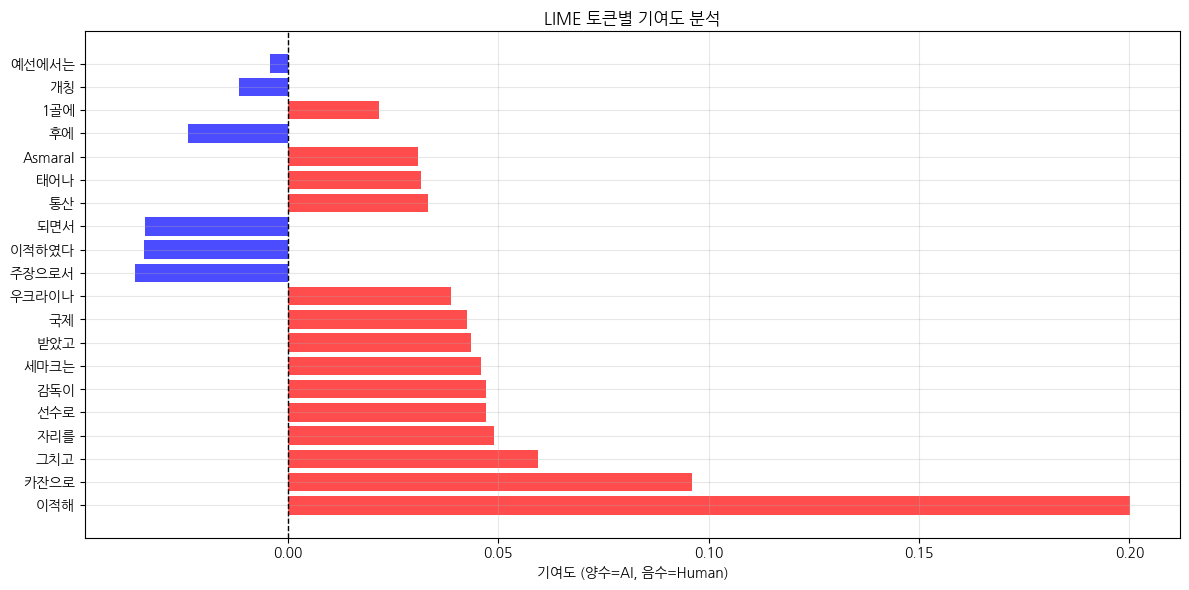

In [28]:
# LIME 기여도를 막대 그래프로
lime_weights = lime_exp.as_list()

words = [w[0] for w in lime_weights]
scores = [w[1] for w in lime_weights]
colors = ['red' if s > 0 else 'blue' for s in scores]

plt.figure(figsize=(12, 6))
plt.barh(words, scores, color=colors, alpha=0.7)
plt.xlabel('기여도 (양수=AI, 음수=Human)')
plt.title('LIME 토큰별 기여도 분석')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'{EXPLAINABILITY_DIR}/lime_bar_chart.png', dpi=300, bbox_inches='tight')
plt.show()

## 4️⃣ 문단별 기여도 분석 (Ablation Study)

각 문단을 제거했을 때 예측이 얼마나 바뀌는지 측정

분석 대상 (label=0): 에덴 동산 또는 에덴(, )은 구약성경의 창세기에서 야훼가 최초의 사람인 아담과 하와를 위해 만들어 살게 했다는 이상향의 이름이다. 아브라함 계통 종교들의 창조 신화에 등장하는 이 정원은 기독교가 세계적으로 전파되면서 널리 알려지게 되었고, 오늘날에는 낙원의 대명사로서 사람들에게 전형적인 낙원상으로 인식되고 있다. 창세기의 창조 이야기를 보면, 네 줄기의 ...

📊 문단별 기여도 분석 결과:
    para_idx                                                                                                paragraph  contribution
0          0  에덴 동산 또는 에덴(, )은 구약성경의 창세기에서 야훼가 최초의 사람인 아담과 하와를 위해 만들어 살게 했다는 이상향의 이름이다. 아브라함 계통 종교들의 창조 신화에 등장하는 이...      0.028963
1          1  에덴이 실제 장소였다고 보는 기독교인들 사이에서는 에덴의 위치는 지금도 논쟁 대상이 되고 있다. 대체로 메소포타미아와 페르시아 만의 티그리스강과 유프라테스강 상류에 있었던 것으로 ...     -0.043583
2          2  에덴이라는 단어는 페르시아어 ‘헤덴(Heden)’에서 유래한 히브리어로 ‘환희의 동산’, ‘태고의 정원’이라는 뜻을 가지고 있다. 또한 수메르어의 에디누(edinu: 평지, 황무지...     -0.026857
3          3  창세기 2:5-9에 따르면, 야훼는 7일간에 걸친 천지창조 후에 최초의 사람 아담을 만들어 그에게 에덴 동산을 일구고 지킬 것을 명령했다. 그리고 동산에 있는 모든 나무에서 열리는...      0.048496
4          4  그런데 이 일을 그날로 야훼가 알게 되었다. 하와가 뱀의 꾐에 빠져 선악과를 먹었다고 고백하자 야훼는 그들에게 벌을 내렸다. 뱀은 앞으로 모든 동물 가운데 

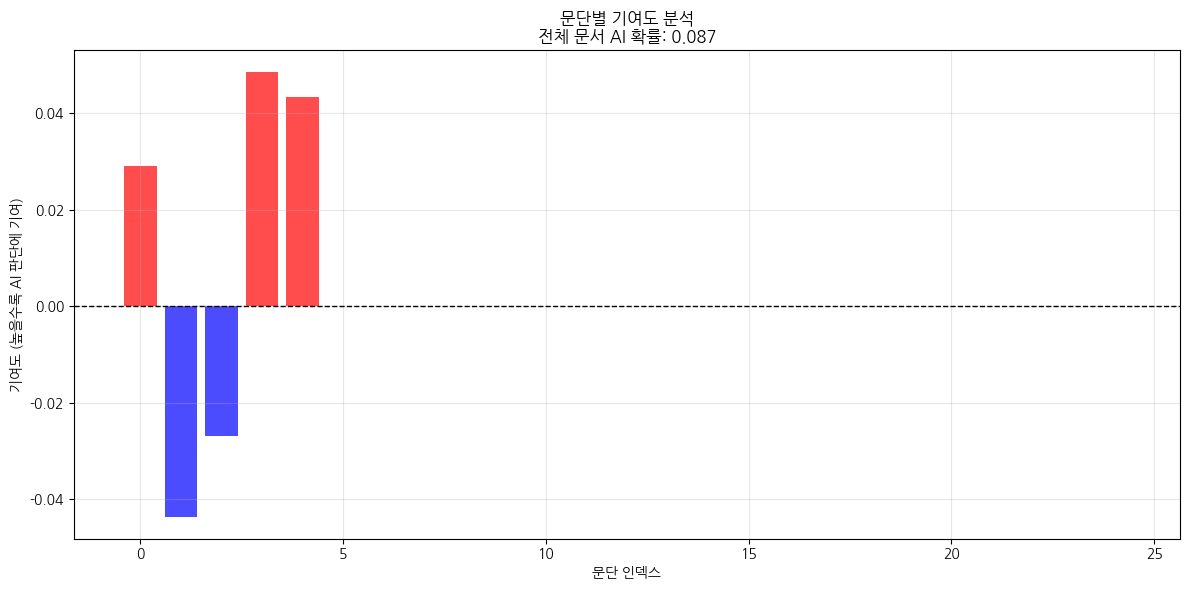

In [29]:
def analyze_paragraph_contribution(full_text, model, tokenizer, device):
    """
    문단별 기여도 분석

    Returns:
        DataFrame with paragraph contributions
    """
    # 문단 분할
    paragraphs = [p.strip() for p in full_text.split('\n') if p.strip()]

    if len(paragraphs) <= 1:
        print("⚠️  문단이 1개 이하입니다.")
        return None

    # 전체 문서 예측
    inputs = tokenizer(full_text, return_tensors='pt', max_length=MAX_LENGTH,
                      padding='max_length', truncation=True)
    with torch.no_grad():
        logits = model(inputs['input_ids'].to(device), inputs['attention_mask'].to(device))
        full_prob = F.softmax(logits, dim=1)[0, 1].item()

    # 각 문단 제거 후 예측
    contributions = []
    for i, para in enumerate(paragraphs):
        # i번째 문단 제거
        remaining_paras = [p for j, p in enumerate(paragraphs) if j != i]
        remaining_text = '\n'.join(remaining_paras)

        inputs = tokenizer(remaining_text, return_tensors='pt', max_length=MAX_LENGTH,
                          padding='max_length', truncation=True)
        with torch.no_grad():
            logits = model(inputs['input_ids'].to(device), inputs['attention_mask'].to(device))
            prob_without = F.softmax(logits, dim=1)[0, 1].item()

        # 기여도 = 전체 - 제거했을 때
        contribution = full_prob - prob_without

        contributions.append({
            'para_idx': i,
            'paragraph': para[:100] + '...' if len(para) > 100 else para,
            'full_paragraph': para,
            'contribution': contribution,
            'prob_without_para': prob_without
        })

    df = pd.DataFrame(contributions)
    df['full_doc_prob'] = full_prob

    return df



# 실제 데이터에서 선택
multi_para_doc = analysis_df.iloc[0]['full_text']  # 첫 번째 샘플
print(f"분석 대상 (label={analysis_df.iloc[0]['generated']}): {multi_para_doc[:200]}...")

contribution_df = analyze_paragraph_contribution(multi_para_doc, model, tokenizer, device)

contribution_df = analyze_paragraph_contribution(multi_para_doc, model, tokenizer, device)

if contribution_df is not None:
    print("\n📊 문단별 기여도 분석 결과:")
    print(contribution_df[['para_idx', 'paragraph', 'contribution']].to_string())

    # 시각화
    plt.figure(figsize=(12, 6))
    colors = ['red' if c > 0 else 'blue' for c in contribution_df['contribution']]
    plt.bar(contribution_df['para_idx'], contribution_df['contribution'], color=colors, alpha=0.7)
    plt.xlabel('문단 인덱스')
    plt.ylabel('기여도 (높을수록 AI 판단에 기여)')
    plt.title(f'문단별 기여도 분석\n전체 문서 AI 확률: {contribution_df["full_doc_prob"].iloc[0]:.3f}')
    plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{EXPLAINABILITY_DIR}/paragraph_contribution.png', dpi=300, bbox_inches='tight')
    plt.show()

## 5️⃣ Interactive 문서 시각화 (Plotly)

문서 전체를 색상으로 표현하고 마우스 오버로 상세 정보 확인

In [30]:
def create_interactive_document_viz(full_text, model, tokenizer, device):
    """
    Interactive 문서 시각화
    """
    # 문단 분할
    paragraphs = [p.strip() for p in full_text.split('\n') if p.strip()]

    # 각 문단의 AI 점수 계산
    para_scores = []
    for para in paragraphs:
        inputs = tokenizer(para, return_tensors='pt', max_length=MAX_LENGTH,
                          padding='max_length', truncation=True)
        with torch.no_grad():
            logits = model(inputs['input_ids'].to(device), inputs['attention_mask'].to(device))
            prob = F.softmax(logits, dim=1)[0, 1].item()
            para_scores.append(prob)

    # HTML 생성 (색상으로 표현)
    html_content = '<div style="font-size: 14px; line-height: 2.0;">'

    for i, (para, score) in enumerate(zip(paragraphs, para_scores)):
        # 색상: 빨강(AI) ~ 파랑(Human)
        red = int(255 * score)
        blue = int(255 * (1 - score))
        color = f'rgb({red}, 100, {blue})'

        html_content += f'<p style="background-color: {color}; padding: 10px; margin: 5px; border-radius: 5px;">'
        html_content += f'<b>[문단 {i+1} | AI 확률: {score:.3f}]</b><br>'
        html_content += para
        html_content += '</p>'

    html_content += '</div>'

    # 저장
    with open(f'{EXPLAINABILITY_DIR}/interactive_doc.html', 'w', encoding='utf-8') as f:
        f.write(html_content)

    # Plotly 시각화
    fig = go.Figure()

    # 문단별 점수 막대 그래프
    fig.add_trace(go.Bar(
        x=[f'문단 {i+1}' for i in range(len(paragraphs))],
        y=para_scores,
        marker_color=para_scores,
        marker_colorscale='RdBu_r',
        marker_cmin=0,
        marker_cmax=1,
        text=[f'{s:.3f}' for s in para_scores],
        textposition='outside',
        hovertext=[p[:200] + '...' if len(p) > 200 else p for p in paragraphs],
        hovertemplate='<b>%{x}</b><br>AI 확률: %{y:.3f}<br><br>%{hovertext}<extra></extra>'
    ))

    fig.update_layout(
        title='문단별 AI 확률 분포',
        xaxis_title='문단',
        yaxis_title='AI 확률',
        yaxis_range=[0, 1.1],
        height=600,
        hovermode='closest'
    )

    # 임계값 선
    fig.add_hline(y=0.5, line_dash='dash', line_color='red',
                  annotation_text='Threshold (0.5)', annotation_position='right')

    fig.write_html(f'{EXPLAINABILITY_DIR}/interactive_plotly.html')

    return fig, para_scores

# 실행
fig, scores = create_interactive_document_viz(multi_para_doc, model, tokenizer, device)
fig.show()

print(f"\n💾 Interactive 시각화 저장:")
print(f"  - {EXPLAINABILITY_DIR}/interactive_doc.html (색상 표현)")
print(f"  - {EXPLAINABILITY_DIR}/interactive_plotly.html (Plotly 차트)")


💾 Interactive 시각화 저장:
  - /content/drive/MyDrive/멋사_프로젝트_01/explainability/interactive_doc.html (색상 표현)
  - /content/drive/MyDrive/멋사_프로젝트_01/explainability/interactive_plotly.html (Plotly 차트)


## 6️⃣ Rationale 자동 추출

"이 문서는 AI입니다. 왜냐하면..." 형식의 자연어 설명 생성

In [31]:
def generate_rationale(full_text, model, tokenizer, device, lime_explainer=None):
    """
    자동 Rationale 생성

    Returns:
        자연어 설명 텍스트
    """
    # 전체 문서 예측
    inputs = tokenizer(full_text, return_tensors='pt', max_length=MAX_LENGTH,
                      padding='max_length', truncation=True)
    with torch.no_grad():
        logits = model(inputs['input_ids'].to(device), inputs['attention_mask'].to(device))
        probs = F.softmax(logits, dim=1)
        ai_prob = probs[0, 1].item()
        predicted_class = 'AI' if ai_prob > 0.5 else 'Human'

    # 문단별 분석
    paragraphs = [p.strip() for p in full_text.split('\n') if p.strip()]
    para_scores = []

    for para in paragraphs:
        inputs = tokenizer(para, return_tensors='pt', max_length=MAX_LENGTH,
                          padding='max_length', truncation=True)
        with torch.no_grad():
            logits = model(inputs['input_ids'].to(device), inputs['attention_mask'].to(device))
            prob = F.softmax(logits, dim=1)[0, 1].item()
            para_scores.append(prob)

    # Rationale 생성
    rationale = f"""# 📝 분석 결과

## 🎯 최종 판정
**이 문서는 {predicted_class}로 예측됩니다. (확률: {ai_prob:.1%})**

## 📊 상세 분석

### 문단별 점수
총 {len(paragraphs)}개 문단 중:
- AI-like (≥0.5): {sum([1 for s in para_scores if s >= 0.5])}개 문단
- Human-like (<0.5): {sum([1 for s in para_scores if s < 0.5])}개 문단
- 평균 AI 점수: {np.mean(para_scores):.3f}

### 주요 근거
"""

    # 가장 AI-like한 문단
    max_idx = np.argmax(para_scores)
    rationale += f"\n**가장 AI스러운 문단 (문단 {max_idx+1}, 점수: {para_scores[max_idx]:.3f})**\n"
    rationale += f"> {paragraphs[max_idx][:150]}...\n"

    # 가장 Human-like한 문단
    min_idx = np.argmin(para_scores)
    rationale += f"\n**가장 Human스러운 문단 (문단 {min_idx+1}, 점수: {para_scores[min_idx]:.3f})**\n"
    rationale += f"> {paragraphs[min_idx][:150]}...\n"

    # LIME 기반 주요 단어 (선택적)
    if lime_explainer:
        try:
            lime_exp = lime_explainer.explain_instance(
                full_text,
                predict_proba_for_lime,
                num_features=10,
                num_samples=100
            )
            top_words = lime_exp.as_list()[:5]

            rationale += "\n### 🔑 결정적인 단어/구절\n"
            for word, score in top_words:
                direction = "AI 방향" if score > 0 else "Human 방향"
                rationale += f"- **{word}**: {abs(score):.3f} ({direction})\n"
        except:
            pass

    # 판단 요약
    rationale += "\n## 💡 종합 의견\n"
    if ai_prob > 0.7:
        rationale += f"이 문서는 **매우 높은 확률({ai_prob:.1%})로 AI가 생성**한 것으로 판단됩니다. "
        rationale += "문단 대부분이 형식적이고 구조화된 문체를 보이며, AI 특유의 패턴이 명확합니다."
    elif ai_prob > 0.5:
        rationale += f"이 문서는 **AI가 생성**한 것으로 판단되나({ai_prob:.1%}), 일부 Human-like한 요소도 포함되어 있습니다."
    elif ai_prob > 0.3:
        rationale += f"이 문서는 **Human이 작성**한 것으로 판단되나({1-ai_prob:.1%}), 일부 AI-like한 표현도 있습니다."
    else:
        rationale += f"이 문서는 **매우 높은 확률({1-ai_prob:.1%})로 Human이 작성**한 것으로 판단됩니다. "
        rationale += "구어체, 개인적 경험, 감정 표현 등이 두드러집니다."

    return rationale, ai_prob, para_scores

# 실행
rationale, prob, scores = generate_rationale(multi_para_doc, model, tokenizer, device, lime_explainer)

print(rationale)

# 저장
with open(f'{EXPLAINABILITY_DIR}/rationale.md', 'w', encoding='utf-8') as f:
    f.write(rationale)

print(f"\n💾 Rationale 저장: {EXPLAINABILITY_DIR}/rationale.md")

# 📝 분석 결과

## 🎯 최종 판정
**이 문서는 Human로 예측됩니다. (확률: 8.7%)**

## 📊 상세 분석

### 문단별 점수
총 25개 문단 중:
- AI-like (≥0.5): 3개 문단
- Human-like (<0.5): 22개 문단
- 평균 AI 점수: 0.255

### 주요 근거

**가장 AI스러운 문단 (문단 19, 점수: 0.828)**
> 중세 연구가들은 에덴 동산의 위치에 대해 매우 낭만적으로 추리해 갔다. 예를 들면, 어느 연대 사학자는 수단과 에티오피아 근방에 에덴이 있다고 상정하고 이렇게 기록했다....

**가장 Human스러운 문단 (문단 6, 점수: 0.037)**
> 이렇게 해서 아담과 하와는 에덴 동산에서 추방되는 벌을 받게 되었다. 그리고 생명 나무로 가는 길을 봉쇄하기 위해서 지식의 천사인 케루빔에게 번쩍이는 불 칼로 무장하게 한 다음 에덴 동산의 동쪽을 지키게 했다....

### 🔑 결정적인 단어/구절
- **전형적인**: 0.014 (AI 방향)
- **돌아온**: 0.010 (AI 방향)
- **끝에서**: 0.008 (AI 방향)
- **다름이**: 0.008 (AI 방향)
- **번째로**: 0.007 (AI 방향)

## 💡 종합 의견
이 문서는 **매우 높은 확률(91.3%)로 Human이 작성**한 것으로 판단됩니다. 구어체, 개인적 경험, 감정 표현 등이 두드러집니다.

💾 Rationale 저장: /content/drive/MyDrive/멋사_프로젝트_01/explainability/rationale.md


## 📋 종합 보고서 생성

In [ ]:
def generate_comprehensive_report(text, model, tokenizer, device, explainability_dir):
    """
    종합 설명가능성 보고서 생성
    """
    print("📊 종합 보고서 생성 중...\n")

    # 1. Rationale
    rationale, prob, para_scores = generate_rationale(text, model, tokenizer, device)

    # 2. Attention 시각화
    fig, tokens, attn, _ = visualize_attention(text, model, tokenizer, device)
    plt.savefig(f'{explainability_dir}/report_attention.png', dpi=300, bbox_inches='tight')
    plt.close()

    # 3. 문단 기여도
    contrib_df = analyze_paragraph_contribution(text, model, tokenizer, device)

    # 4. Interactive 시각화
    fig_interactive, _ = create_interactive_document_viz(text, model, tokenizer, device)

    # 5. 종합 HTML 보고서
    report_html = f"""
    <!DOCTYPE html>
    <html>
    <head>
        <meta charset="utf-8">
        <title>AI/Human 분류 설명가능성 보고서</title>
        <style>
            body {{ font-family: 'Nanum Gothic', sans-serif; margin: 20px; background: #f5f5f5; }}
            .container {{ max-width: 1200px; margin: 0 auto; background: white; padding: 30px; border-radius: 10px; box-shadow: 0 2px 10px rgba(0,0,0,0.1); }}
            h1 {{ color: #2c3e50; border-bottom: 3px solid #3498db; padding-bottom: 10px; }}
            h2 {{ color: #34495e; margin-top: 30px; }}
            .prediction {{ background: #ecf0f1; padding: 20px; border-radius: 5px; margin: 20px 0; }}
            .ai {{ background: #ffe6e6; }}
            .human {{ background: #e6f3ff; }}
            img {{ max-width: 100%; height: auto; margin: 20px 0; }}
            table {{ width: 100%; border-collapse: collapse; margin: 20px 0; }}
            th, td {{ padding: 12px; text-align: left; border-bottom: 1px solid #ddd; }}
            th {{ background-color: #3498db; color: white; }}
        </style>
    </head>
    <body>
        <div class="container">
            <h1>🔍 AI/Human 텍스트 분류 설명가능성 보고서</h1>

            <div class="prediction {'ai' if prob > 0.5 else 'human'}">
                <h2>🎯 최종 판정</h2>
                <p style="font-size: 18px;"><strong>{'AI' if prob > 0.5 else 'Human'}</strong> (확률: <strong>{prob:.1%}</strong>)</p>
            </div>

            <h2>📝 분석 텍스트</h2>
            <div style="background: #f9f9f9; padding: 15px; border-left: 4px solid #3498db; font-family: monospace;">
                {text[:500]}{'...' if len(text) > 500 else ''}
            </div>

            <h2>📊 Attention Weights 시각화</h2>
            <img src="report_attention.png" alt="Attention Heatmap">

            <h2>📈 문단별 기여도</h2>
            {'<p>단일 문단이므로 기여도 분석 생략</p>' if contrib_df is None else contrib_df.to_html(index=False)}

            <h2>💡 종합 분석</h2>
            <div style="white-space: pre-wrap;">{rationale}</div>

            <hr style="margin: 40px 0;">
            <p style="text-align: center; color: #7f8c8d;">Generated by BERT Explainability System</p>
        </div>
    </body>
    </html>
    """

    with open(f'{explainability_dir}/comprehensive_report.html', 'w', encoding='utf-8') as f:
        f.write(report_html)

    print("✅ 종합 보고서 생성 완료!")
    print(f"📁 저장 위치: {explainability_dir}/comprehensive_report.html")

    return report_html

# 실행
report = generate_comprehensive_report(multi_para_doc, model, tokenizer, device, EXPLAINABILITY_DIR)

print("\n" + "="*60)
print("🎉 모든 설명가능성 분석 완료!")
print("="*60)
print(f"\n📁 생성된 파일:")
print(f"  - {EXPLAINABILITY_DIR}/comprehensive_report.html (종합 보고서)")
print(f"  - {EXPLAINABILITY_DIR}/attention_sample_*.png (Attention 시각화)")
print(f"  - {EXPLAINABILITY_DIR}/lime_explanation.html (LIME 분석)")
print(f"  - {EXPLAINABILITY_DIR}/paragraph_contribution.png (문단 기여도)")
print(f"  - {EXPLAINABILITY_DIR}/interactive_*.html (인터랙티브 시각화)")
print(f"  - {EXPLAINABILITY_DIR}/rationale.md (Rationale)")